# A simple example of parallel computing with Dask on ARM data

**Dask** is a great tool for taking a problem an distrubuting across many cores. This is a **simple example** as in you really could just do this in series. but it neatly shows how easy it is to map a problem to a cluster.  

Now is a great time to learn how to use Dask as there is massive uptake in the community including NSF/NASA funded [Pangeo](https://pangeo.io/)

In [1]:
#imports
import os # Code for dealing with the file system
import numpy as np
from matplotlib import pyplot as plt
from dask.distributed import Client, progress, metrics, LocalCluster
import xarray as xr
%matplotlib inline

First few cells deal with reading data into an X-Array object and work on ONE data file

In [2]:
in_directory = '/lustre/or-hydra/cades-arm/proj-shared/data_transfer/sgp/sgpmetE13.b1/'

Create and sort a list of files.


In [3]:
all_files = os.listdir(in_directory)
all_files.sort()

In [4]:
test_file_name = os.path.join(in_directory, all_files[23])
test_dataset = xr.open_dataset(test_file_name)

X-Array is awesome. It is very rich and couples very nicely to ARM data. 

In [5]:
test_dataset.time[0].values

numpy.datetime64('2018-01-23T00:00:00.000000000')

Lets plot one day's worth of data


/home/jupyter/anaconda3/envs/daskenv/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


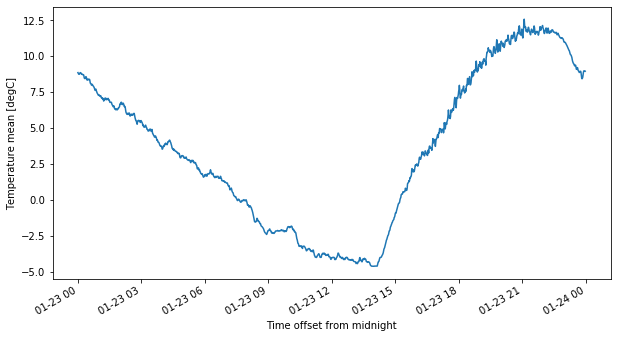

In [6]:
my_figure = plt.figure(figsize=[10,5])
test_dataset.temp_mean.plot()

So the specific application we want: What is the min, mean and max temperature for a day? (of course this is a UTC day)

In [7]:
my_mean = float(test_dataset.temp_mean.mean())
my_max = float(test_dataset.temp_mean.max())
my_min = float(test_dataset.temp_mean.min())

In [8]:
print("Mean: {}, Max: {}, Min: {}".format(my_mean, my_max, my_min ))

Mean: 3.5054805278778076, Max: 12.569999694824219, Min: -4.632999897003174


Good housekeeping, close the file (this gets you into all kind of trouble when doing distributed computing)

In [9]:
test_dataset.close()

## So, here is your Distrubuted computing 101. 
To use something like Dask you want to break your problem down into repeated tasks. Then instead of looping you do a *Map Reduce*. Create a function that you want to map onto a list of "things". In our case it is a function that opens a data file, returns the time, mean, min and max.

In [10]:
def analyze_this_days_temps(filename):
    this_dataset = xr.open_dataset(filename)
    my_mean = float(this_dataset.temp_mean.mean())
    my_max = float(this_dataset.temp_mean.max())
    my_min = float(this_dataset.temp_mean.min())
    this_dataset.close()
    return this_dataset.time[0].values, my_mean, my_max, my_min

Now we append the path to each file. 

In [11]:
fqn_files = [os.path.join(in_directory,thisfile) for thisfile in all_files]

test our function on one file

In [12]:
analyze_this_days_temps(fqn_files[1])

(numpy.datetime64('2018-01-02T00:00:00.000000000'),
 -10.4390869140625,
 -6.383999824523926,
 -12.8100004196167)

**For this workshop** we connect to an already running Dask cluster. If you want some examples on how to start and configure clusters see me (or even better, Bobby). 

In [13]:
client = Client('arm-jupyter.ornl.gov:5555')

Lets look at the client... This cluster dynamically scales.. This cell will update 

In [14]:
client

Client Scheduler: tcp://arm-jupyter.ornl.gov:5555 Dashboard: http://arm-jupyter.ornl.gov:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


**Here is the magic!** Map the list of files to the function...

In [15]:
future = client.map(analyze_this_days_temps, fqn_files)

**Show me the PROGRESS!**


In [16]:
progress(future)

VBox()

Once it is done gather the data from the complete processes. (Map, then reduce) 

In [17]:
my_data = client.gather(future)

In [18]:
times = np.array([tpl[0] for tpl in my_data])
means = np.array([tpl[1] for tpl in my_data])
maxs = np.array([tpl[2] for tpl in my_data])
mins = np.array([tpl[3] for tpl in my_data])

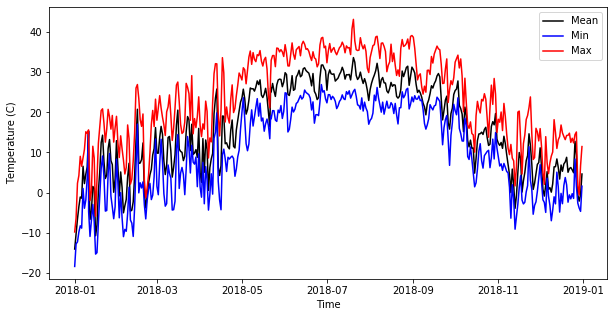

In [19]:
my_fig = plt.figure(figsize=[10,5])
plt.plot(times, means, '-k', label='Mean')
plt.plot(times, mins, '-b', label='Min')
plt.plot(times, maxs, '-r', label='Max')
plt.ylabel('Temperature (C)')
plt.xlabel('Time')
plt.legend()
